In [1]:
data_location = 'sqlite:///../../../data/data.db'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from functools import reduce

from pandas.plotting import scatter_matrix, autocorrelation_plot


In [ ]:
# Borrowing vol_ohlc and plot_learning_curve functions from Lecture

In [3]:
def vol_ohlc(df, lookback):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [15]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring=None
):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
        scoring=scoring,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [4]:
ohlc = pd.read_sql('SELECT * FROM ohlc', data_location)
tokens = ohlc.token.unique()

In [26]:
def df_merge(left, right):
    return pd.merge(left, right, on='ts', how='inner')

X = reduce(df_merge, [
    (lambda df: 
    (
        df
        .assign(
            vol=vol_ohlc(df, 10).fillna(0),
            ret=df.close.pct_change()
        )[['ts', 'vol', 'ret']]
        .rename(columns={
            col: f'{col}_{token}' for col in ['ts', 'vol', 'ret'] if col != 'ts'
        })
    ))(ohlc[ohlc.token == token])
    for token in tokens
]).set_index('ts')

In [27]:
Y = X.ret_SOL.shift(-1)[:-1]
X = X[:-1]
Y.describe()

count    1056.000000
mean       -0.000156
std         0.012010
min        -0.053429
25%        -0.007444
50%        -0.000503
75%         0.006740
max         0.048298
Name: ret_SOL, dtype: float64

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

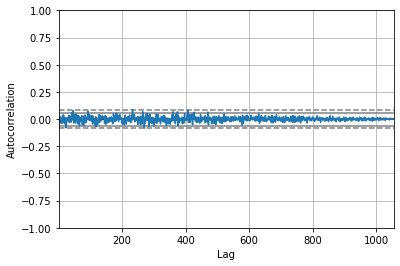

In [7]:
autocorrelation_plot(Y[1:])

In [8]:
{col: Y.corr(X[col]) for col in X.columns if X[col].dtype != 'object'}

{'vol_BTC': 0.028693550573573316,
 'ret_BTC': -0.013848623804147297,
 'vol_ETH': 0.02357151289469286,
 'ret_ETH': 0.03064921265933825,
 'vol_USDT': 0.006850180191310921,
 'ret_USDT': -0.044400854990527476,
 'vol_SOL': 0.03485259726638474,
 'ret_SOL': -0.02985506419340651,
 'vol_ADA': 0.03888023343700741,
 'ret_ADA': 0.0002492833396142092,
 'vol_DOT': 0.059040768451671846,
 'ret_DOT': 0.008193946995455023,
 'vol_AVAX': 0.04140851156078151,
 'ret_AVAX': 0.01691945028976708,
 'vol_ATOM': -0.0022346077856851623,
 'ret_ATOM': 0.05546161881659775,
 'vol_CRV': 0.019828890149893363,
 'ret_CRV': -0.005844145396121401,
 'vol_AAVE': 0.03605077807280678,
 'ret_AAVE': 0.01989568673206619,
 'vol_COMP': 0.05984258530861503,
 'ret_COMP': 0.020113141490153065}

In [41]:
# Import sklearn libraries
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.model_selection import learning_curve

In [10]:
# Define the FeatureSelector class
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, Y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]

In [11]:
# Evaluate the performance of the model
def evaluate_model(model, X, Y, test_size=0.2):
    cv = TimeSeriesSplit(n_splits=int(Y.shape[0] * test_size), test_size=1)
    scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
    
    return np.mean(cross_validate(model, X, Y, cv=cv, scoring=scorer, n_jobs=-1)['test_score'])
    

In [12]:
# Run the best in-class model; this is the target model that we are trying to beat
in_class_model = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=20)),
    ('model', Ridge(alpha=0.1))
])

evaluate_model(in_class_model, X, Y)

-0.008575141851714435

In [13]:
test_size = 0.2
cv = TimeSeriesSplit(n_splits=int(Y.shape[0] * test_size), test_size=1)
scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

<module 'matplotlib.pyplot' from '/Users/Anirudh/opt/anaconda3/envs/mfe-preprogram/lib/python3.8/site-packages/matplotlib/pyplot.py'>

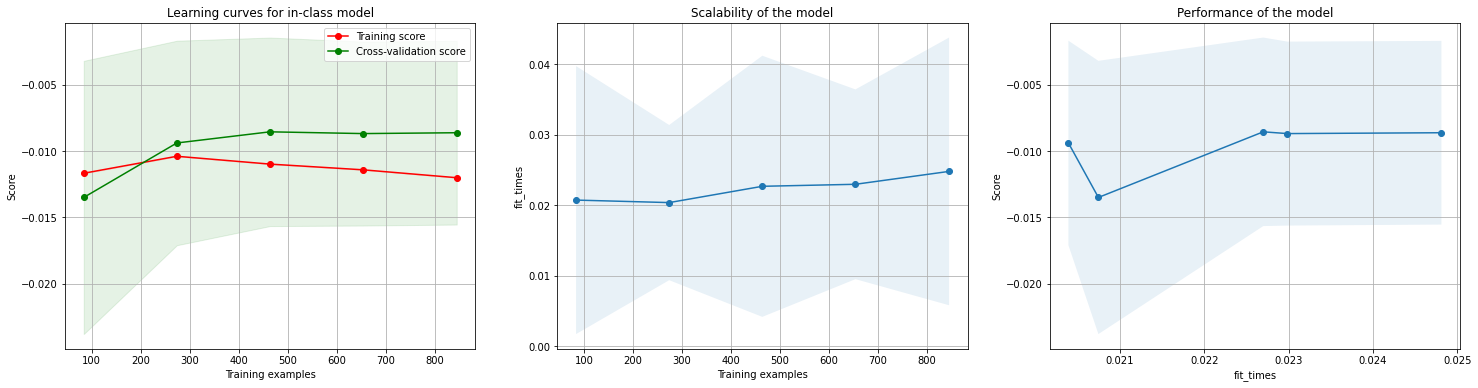

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(25, 6))

title = "Learning curves for in-class model"

plot_learning_curve(
    in_class_model, title, X, Y, axes=axes, cv=cv, n_jobs=4, scoring=scorer
)

In [ ]:
# From here onwards the following cells will be dedicated to feature engineering and beating the
#    performance of the in-class model

In [17]:
# One feature we can adjust is the lookback window used to calculate vol_ohlc.
#   I modified the function to take the lookback as a parameter and will attempt
#   to build a better model by using a shorter lookback of 7.
#   The idea is that the shorter lookback will capture more of the vol in the near term and the model can
#   forecast more accurate hourly returns.

In [28]:
# Follow the same initial steps to prepare the data for the model:
def df_merge(left, right):
    return pd.merge(left, right, on='ts', how='inner')

X_new = reduce(df_merge, [
    (lambda df: 
    (
        df
        .assign(
            vol=vol_ohlc(df, 7).fillna(0),
            ret=df.close.pct_change()
        )[['ts', 'vol', 'ret']]
        .rename(columns={
            col: f'{col}_{token}' for col in ['ts', 'vol', 'ret'] if col != 'ts'
        })
    ))(ohlc[ohlc.token == token])
    for token in tokens
]).set_index('ts')

In [30]:
Y_new = X_new.ret_SOL.shift(-1)[:-1]
X_new = X_new[:-1]
{col: Y_new.corr(X_new[col]) for col in X_new.columns if X_new[col].dtype != 'object'}

{'vol_BTC': -0.011961461084672628,
 'ret_BTC': -0.013845909960858136,
 'vol_ETH': 0.010207347724836243,
 'ret_ETH': 0.03073543182041082,
 'vol_USDT': -0.002955582726261861,
 'ret_USDT': -0.04451516610926519,
 'vol_SOL': 0.03388230143597692,
 'ret_SOL': -0.029689685892457303,
 'vol_ADA': 0.029082309113676034,
 'ret_ADA': 0.0002449473670753522,
 'vol_DOT': 0.04041716621357109,
 'ret_DOT': 0.008233873053433165,
 'vol_AVAX': 0.03539695942056109,
 'ret_AVAX': 0.016538692080520452,
 'vol_ATOM': -0.013890738640845899,
 'ret_ATOM': 0.05561990570055823,
 'vol_CRV': -0.008376138840287215,
 'ret_CRV': -0.005710333663152821,
 'vol_AAVE': 0.009893557739196857,
 'ret_AAVE': 0.019949504556739828,
 'vol_COMP': 0.039694427971699135,
 'ret_COMP': 0.020119922588613847}

In [32]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X_new, Y_new=None):
        return self
    
    def transform(self, X_new):
        return X_new[self.columns]

In [33]:
test_size = 0.2
cv = TimeSeriesSplit(n_splits=int(Y_new.shape[0] * test_size), test_size=1)
scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

In [34]:
def evaluate_model(model, X_new, Y_new, test_size=0.2):
    cv = TimeSeriesSplit(n_splits=int(Y_new.shape[0] * test_size), test_size=1)
    scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
    
    return np.mean(cross_validate(model, X_new, Y_new, cv=cv, scoring=scorer, n_jobs=-1)['test_score'])

In [50]:
# Build the hw model here
hw_model = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=22)),
    ('model', Ridge(alpha=0.1))
])

evaluate_model(hw_model, X_new, Y_new)

-0.008529977125981077

<module 'matplotlib.pyplot' from '/Users/Anirudh/opt/anaconda3/envs/mfe-preprogram/lib/python3.8/site-packages/matplotlib/pyplot.py'>

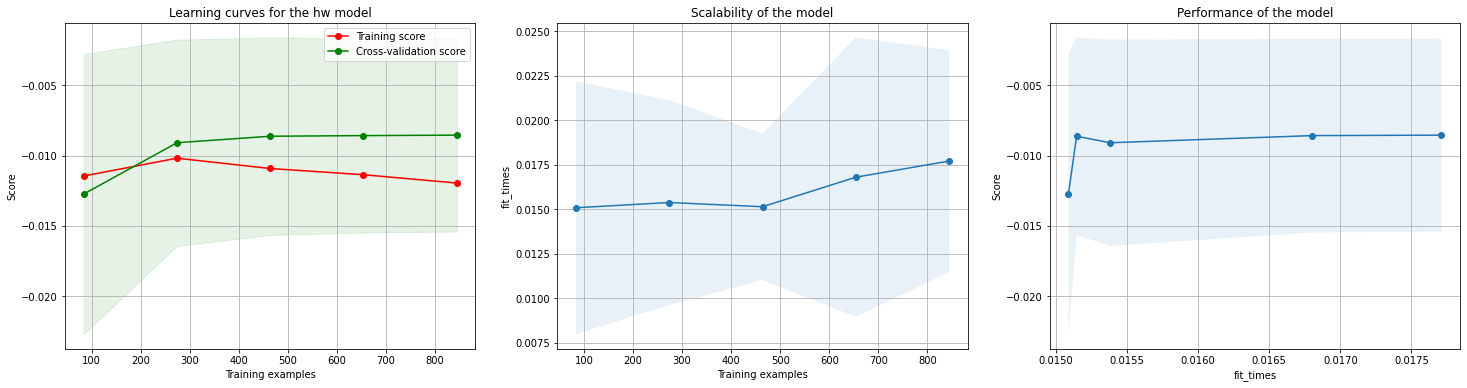

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(25, 6))

title = "Learning curves for the hw model"

plot_learning_curve(
    hw_model, title, X_new, Y_new, axes=axes, cv=cv, n_jobs=4, scoring=scorer
)

In [ ]:
# We achieve a better performance with this model, howeve the scalability, and training score suffer with larger samples.
# I also tried (but not included due to poorer performance) using the random forest regressor and using grid search to vary
# the max_depth.
# This model sucessfully beats the in-class model: -0.008529977125981077